# Milestone 3: Training the semi-supervised GAN for melanoma image classification

In [ ]:
import os
from os import listdir
from os.path import join

from PIL import Image
import random

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import copy

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import utils, models
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms

def set_seed(seed):

    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)

def is_image(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

class UnlabeledDataset(Dataset):

    def __init__(self, dir_path, transform=None):
        """
        Args:
            dir_path (string): Directory containing the images.
            transform (optional): Optional transform to be applied
                on an image.
        """

        self.transform = transform
        
        # The list of all the image file names (but not the images themselves!) will be read
        # when the Dataset object is initialized
        self.image_filenames = [join(dir_path, f) for f in listdir(dir_path) if is_image(f)]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        
        # Here is where the image actually gets read:
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image
    
    
class LabeledDataset(Dataset):

    def __init__(self, dir_path, transform=None):
        """
        Args:
            dir_path (string): Directory containing the images.
            transform (optional): Optional transform to be applied
                on an image.
        """

        self.transform = transform
        
        # The list of all the image file names (but not the images themselves!) will be read
        # when the Dataset object is initialized
        self.image_filenames = [join(dir_path, f) for f in listdir(dir_path) if is_image(f)]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        
        # Here is where the image actually gets read:
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)
            
        label = int(img_name[-5])

        return image, label
    
rotation = transforms.RandomChoice([transforms.RandomRotation([-3,3]),
                                    transforms.RandomRotation([87,93]), 
                                    transforms.RandomRotation([177,183]),
                                    transforms.RandomRotation([267, 273])])

augmentation = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), 
                                   rotation])
    
unlabeled_set = UnlabeledDataset('MelanomaDetection/unlabeled',     
                               transform=transforms.Compose([augmentation, transforms.ToTensor()]))
labeled_set = LabeledDataset('MelanomaDetection/labeled',     
                             transform=transforms.Compose([augmentation, transforms.ToTensor()]))

set_seed(1) # Setting the random seed will allow us to use the same exact train / val split

train_set, val_set = torch.utils.data.random_split(labeled_set, [int(0.7*len(labeled_set)), int(0.3*len(labeled_set))])
 
test_set = LabeledDataset('MelanomaDetection/test', transform=transforms.ToTensor())  

print('Number of unlabeled TRAIN images: ', len(unlabeled_set))
print('Number of labeled TRAIN images: ', len(train_set))
print('Number of VAL images: ', len(val_set))
print('Number of TEST images: ', len(test_set))

unlabeled_loader = DataLoader(unlabeled_set, batch_size=256, shuffle=True, num_workers=10)
labeled_loader = DataLoader(train_set, batch_size=len(train_set), shuffle=False, num_workers=1)
val_loader = DataLoader(val_set, batch_size=len(val_set), shuffle=False, num_workers=1)
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False, num_workers=1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Since we only have one batch of labeled data, we might as well get it in
# the form of a PyTorch tensor now:
labeled_batch = next(iter(labeled_loader))
labeled_data = labeled_batch[0].to(device)
labels = labeled_batch[1].to(device)

Number of unlabeled TRAIN images:  7018
Number of labeled TRAIN images:  140
Number of VAL images:  60
Number of TEST images:  600


## The semi-supervised GAN

In [ ]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.3

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Discriminator (Classifier) Code

num_classes = 2

class Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.main = nn.Sequential(
            # state size. (ndc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, n_classes, 4, 1, 0, bias=False),
        )
    def forward(self, input):
        return self.main(input)

In [ ]:
def log_sum_exp(x, axis = 1):
    m = torch.max(x, dim = 1)[0]
    return m + torch.log(torch.sum(torch.exp(x - m.unsqueeze(1)), dim = axis))

# Training loop       
def train_SSL_GAN(generator, classifier, unlabeled_loader, labeled_data, labels, val_loader, device, 
                  optimizerG, optimizerC, epochs):

    val_losses = []
    val_accuracies = []

    best_model_wts = copy.deepcopy(classifier.state_dict())
    best_acc = 0.0

    for epoch in range(1, epochs + 1):

        for batch in unlabeled_loader:
        
            # TRAIN THE DISCRIMINATOR (THE CLASSIFIER)
            classifier.train()
            optimizerC.zero_grad()
        
            # 1. on Unlabelled data
            data = batch.to(device)
            outputs = classifier(data)    
            logz_unlabel = log_sum_exp(outputs)
            lossUL = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
            lossUL.backward()  
        
            # 2. on the generated data

            noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
            generated = (netG(noise)+1.0)/2.0
            outputs = classifier(generated.detach()) # detach() because we are not training G here
            logz_fake = log_sum_exp(outputs)
            lossD = 0.5*torch.mean(F.softplus(logz_fake))
            lossD.backward()
        
            # 3. on labeled data
            output = classifier(labeled_data).squeeze()
            logz_label = log_sum_exp(output)
            prob_label = torch.gather(output, 1, labels.unsqueeze(1))
            labeled_loss = -torch.mean(prob_label) + torch.mean(logz_label)
            labeled_loss.backward()    

            optimizerC.step()
        
            # TRAIN THE GENERATOR
            netG.train()
            optimizerG.zero_grad()
        
            outputs = classifier(generated)
            logz_unlabel = log_sum_exp(outputs)
            lossG = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
            lossG.backward()
            optimizerG.step()
        
            val_loss, val_accuracy = test(classifier, device, val_loader, False)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
        
            if val_accuracy > best_acc:
                best_acc = val_accuracy
                best_classifier_wts = copy.deepcopy(classifier.state_dict())
            
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('VAL loss', color=color)
    ax1.plot(range(len(np.array(val_losses))), np.array(val_losses), color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx() 

    color = 'tab:blue'
    ax2.set_ylabel('VAL accuracy', color=color)  
    ax2.plot(range(len(np.array(val_losses))), np.array(val_accuracies), color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()
   
    print('Highest accuracy on the VAL set: ', np.max(val_accuracies))
        
    classifier.load_state_dict(best_classifier_wts)
    return classifier

In [ ]:
criterion = nn.CrossEntropyLoss()

def test(model, device, test_loader, display=False):
    
    # eval() is the mode that "turns off" the non-deterministic layers
    # that may be present in the model (e.g. dropout, batchnorm, etc)
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.type(torch.LongTensor).to(device)
            output = model(data)
            test_loss += criterion(output.squeeze(), target.squeeze()).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)  
    
    if display:
        print('Test set accuracy: ',(100. * correct / len(test_loader.dataset)))
    
    return test_loss, (100. * correct / len(test_loader.dataset))

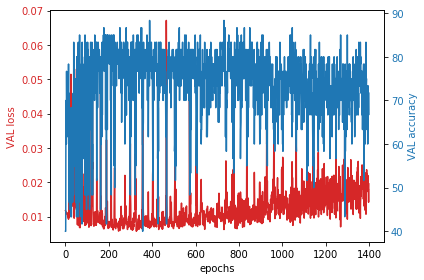

Highest accuracy on the VAL set:  88.33333333333333
Test set accuracy:  78.5


(0.0009524547060330709, 78.5)

In [ ]:
set_seed(1)

netG = Generator().to(device)
netG.apply(weights_init)

classifier = Classifier(n_classes=num_classes).to(device)
classifier.apply(weights_init)

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas= (beta1, 0.999))
optimizerC = optim.Adam(classifier.parameters(), lr=lr, betas= (beta1, 0.999))

# Train the semi-supervised GAN   
model = train_SSL_GAN(netG, classifier, unlabeled_loader, labeled_data, labels, 
                      val_loader, device, optimizerG, optimizerC, 50)

# Test the semi-supervised GAN
test(model, device, test_loader, True)